In [53]:
import pandas as pd

# Load the dataset into a pandas dataframe
df = pd.read_csv('tracks.csv')

# Select a random sample of 20% of the data
df = df.sample(frac=0.2, random_state=42)


Popularity Statistics:

mean      27.562795
median    27.000000
25%       13.000000
75%       40.000000
std       18.292529
Name: popularity, dtype: float64


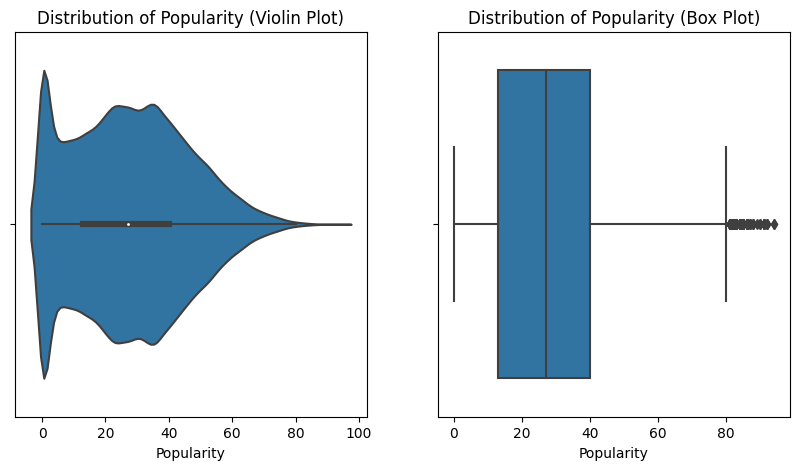

In [54]:
#First let us examine the distribution of popularity in the dataset
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the mean, median, quartiles, and variance of popularity
popularity_stats = df['popularity'].describe()[['mean', '50%', '25%', '75%', 'std']]
popularity_stats.rename(index={'50%': 'median'}, inplace=True)

print('Popularity Statistics:\n')
print(popularity_stats)

# Create a violin plot and box plot of popularity
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.violinplot(x=df['popularity'], ax=axes[0])
axes[0].set_title('Distribution of Popularity (Violin Plot)')
axes[0].set_xlabel('Popularity')

sns.boxplot(x=df['popularity'], ax=axes[1])
axes[1].set_title('Distribution of Popularity (Box Plot)')
axes[1].set_xlabel('Popularity')

plt.show()

Based on this we cann see that on average a song's popularity is 27.56 and there is a high variance of 18.29. On the box plot, we can see a considerable number on anomolies. Moving forward, we will try to account for factors that contribute to such outliers.

## Duration and Popularity

Duration Statistics:

mean      230283 ms
median    214987 ms
25%       175213 ms
75%       264000 ms
std       126151 ms
Name: duration_ms, dtype: object


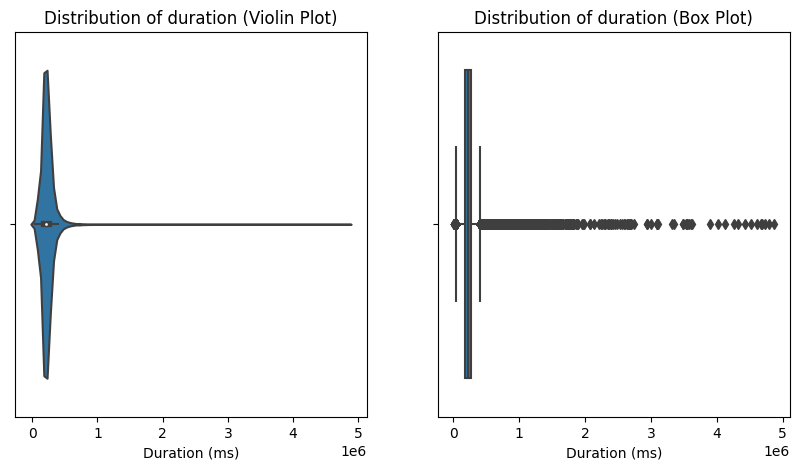

In [55]:
# Calculate the mean, median, quartiles, and variance of duration
duration_stats = df['duration_ms'].describe()[['mean', '50%', '25%', '75%', 'std']]
duration_stats.rename(index={'50%': 'median'}, inplace=True)
duration_stats = duration_stats.astype(int).astype(str) + ' ms'

print('Duration Statistics:\n')
print(duration_stats)

# Create a violin plot and box plot of duration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.violinplot(x=df['duration_ms'], ax=axes[0])
axes[0].set_title('Distribution of duration (Violin Plot)')
axes[0].set_xlabel('Duration (ms)')

sns.boxplot(x=df['duration_ms'], ax=axes[1])
axes[1].set_title('Distribution of duration (Box Plot)')
axes[1].set_xlabel('Duration (ms)')

plt.show()

Based on this distirbution, we can see a high number of anomolies on one side as well. Next, let us see if this accounts for popularity in any case

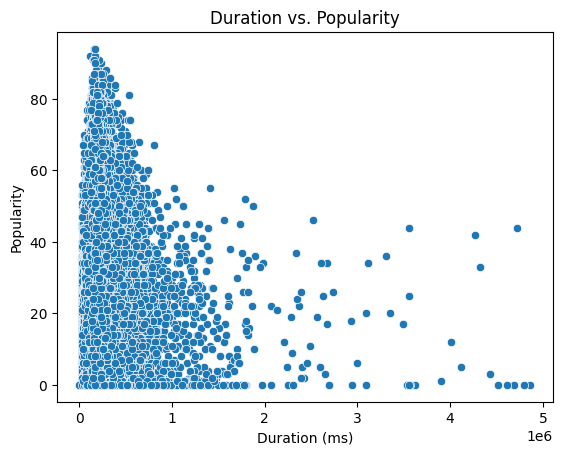

Correlation coefficient: 0.026198844435751677


In [56]:
#Next, let us see if there is a direct relationship between duration and popularity through a scatter plot

# Create a scatter plot of duration_ms vs. popularity
sns.scatterplot(x='duration_ms', y='popularity', data=df)

# Set the plot title and axis labels
plt.title('Popularity vs. Duration')
plt.xlabel('Duration (ms)')
plt.ylabel('Popularity')

# Show the plot
plt.show()


# Calculate the correlation coefficient between duration_ms and popularity
corr = df['duration_ms'].corr(df['popularity'])

# Print the correlation coefficient to the console
print('Correlation coefficient:', corr)

Based on this, we see that the correlation coefficient is extremely low and popularity does not seem to be related to duration at all. However, we notice that songs with popularity over 60 always have a relatively low duration. Let us now account for this using a new analysis method - Clusetering

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Duration Range by Cluster (in ms):
                min         max
cluster                        
0         345090 ms   744587 ms
1           4000 ms   208188 ms
2        2135307 ms  4864333 ms
3         746507 ms  2072133 ms
4         208193 ms   345067 ms


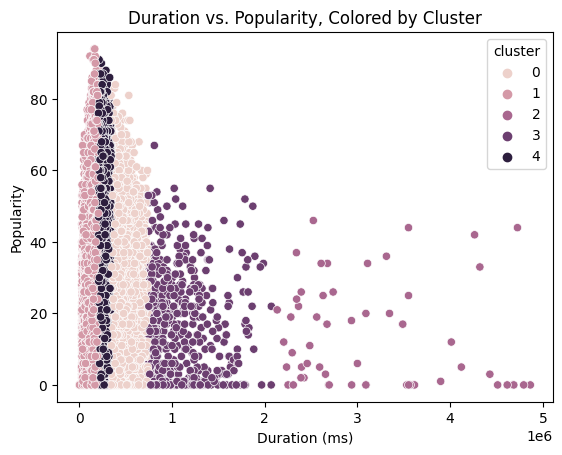

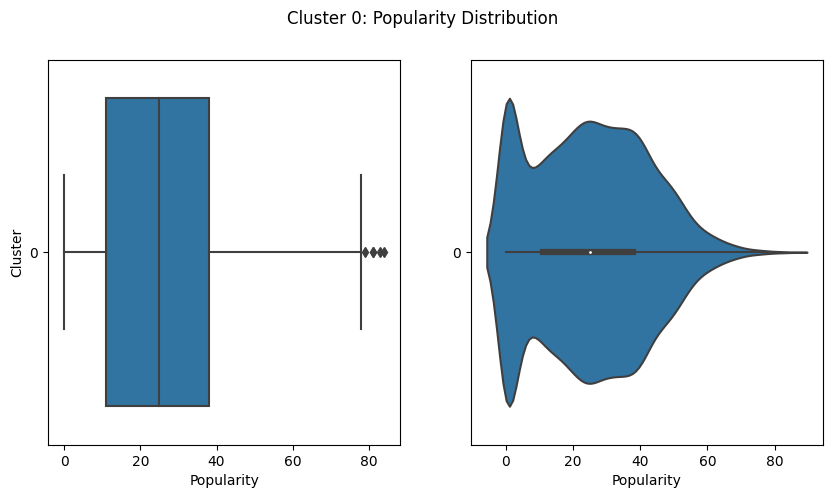

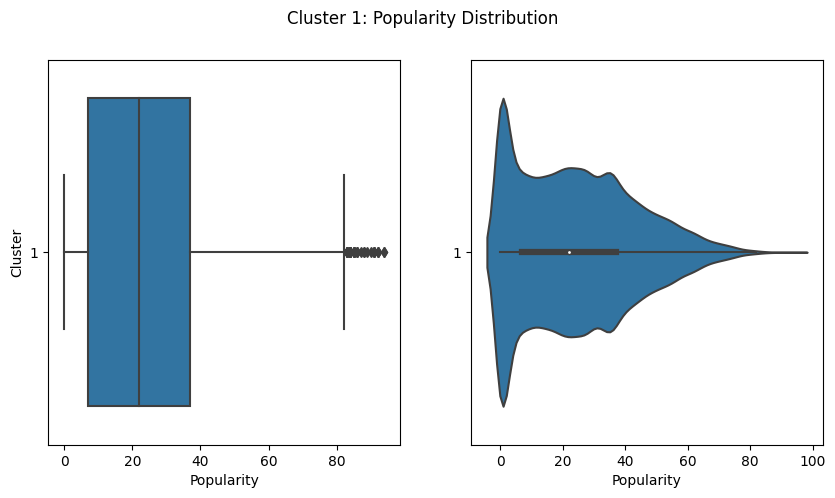

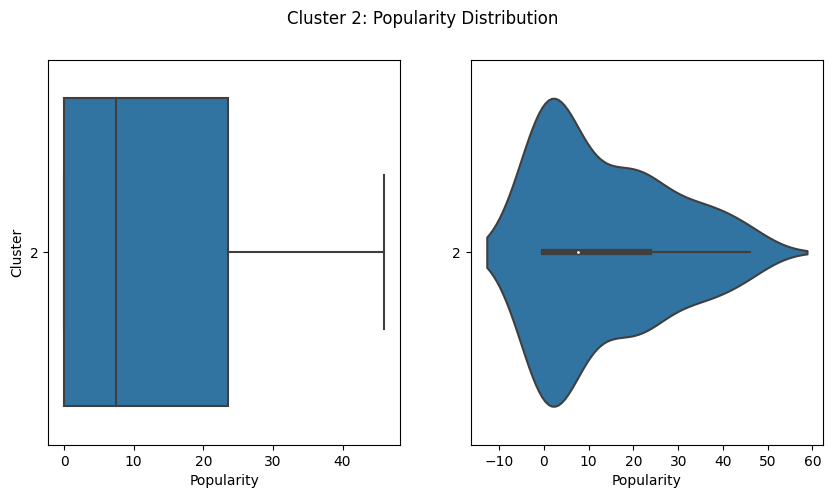

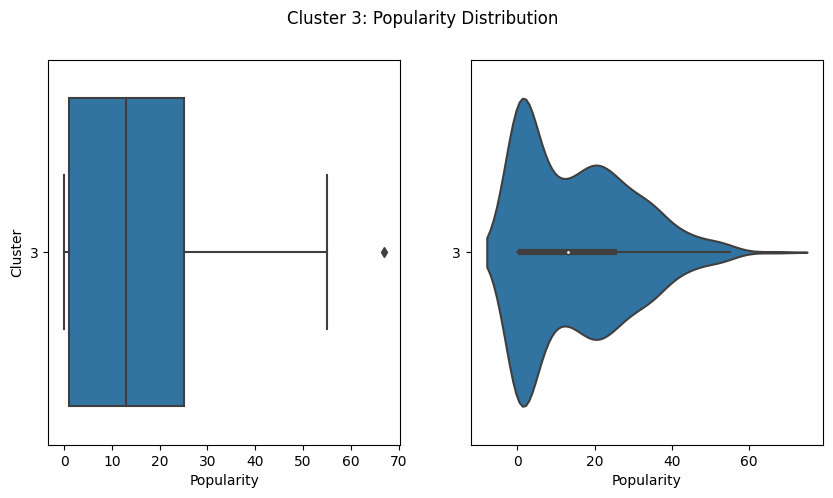

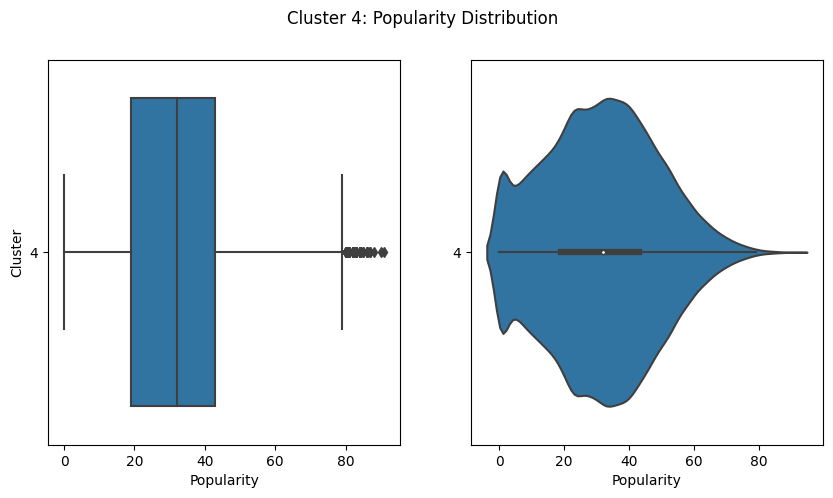

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Extract the duration and popularity features
X = df[['duration_ms', 'popularity']]

# Perform k-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

# Add the cluster labels to the dataframe
df['cluster'] = labels

# Group the DataFrame by cluster labels and calculate the duration range for each cluster
cluster_duration_range = df.groupby('cluster')['duration_ms'].agg(['min', 'max'])

# Add the unit "ms" to the duration range values
cluster_duration_range['min'] = cluster_duration_range['min'].apply(lambda x: str(x) + ' ms')
cluster_duration_range['max'] = cluster_duration_range['max'].apply(lambda x: str(x) + ' ms')

# Print the duration range for each cluster
print("Duration Range by Cluster (in ms):")
print(cluster_duration_range)

# Create a scatterplot of duration vs. popularity, colored by cluster
sns.scatterplot(data=df, x='duration_ms', y='popularity', hue='cluster')
plt.title('Duration vs. Popularity, Colored by Cluster')
plt.xlabel('Duration (ms)')
plt.ylabel('Popularity')
plt.show()

# Create boxplots and violin plots of popularity for each cluster
for i in range(5):
    cluster_data = df.loc[df['cluster'] == i]
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    sns.boxplot(x='popularity', y='cluster', data=cluster_data, orient='horizontal', ax=axes[0])
    sns.violinplot(x='popularity', y='cluster', data=cluster_data, orient='horizontal', ax=axes[1])
    fig.suptitle(f"Cluster {i}: Popularity Distribution")
    axes[0].set_xlabel('Popularity')
    axes[1].set_xlabel('Popularity')
    axes[0].set_ylabel('Cluster')
    axes[1].set_ylabel('')
    plt.show()


Here, we see a significant difference in each of these cluseters which has to be proven to prove our hypothesis that one cluster is better than another when it comes to popularity. As our data is not normally distirbuted, we will use the Kruskal-Wallis test to determine if a cluster is better than the other. If the p-value of the Kruskal-Wallis test is less than the chosen significance level (e.g. 0.05), we can reject the null hypothesis and conclude that at least one of the groups has a different median than the others.

In [58]:
from scipy.stats import kruskal

# Calculate the median popularity for each cluster
cluster_medians = df.groupby('cluster')['popularity'].median()

# Perform Kruskal-Wallis test
stat, pval = kruskal(*[cluster_data['popularity'].values for _, cluster_data in df.groupby('cluster')])

# Print the median popularity for each cluster
print("Median Popularity by Cluster:")
print(cluster_medians)

# Print the Kruskal-Wallis test results
print("Kruskal-Wallis Test Results:")
print("Test statistic:", stat)
print("p-value:", pval)

Median Popularity by Cluster:
cluster
0    25.0
1    22.0
2     7.5
3    13.0
4    32.0
Name: popularity, dtype: float64
Kruskal-Wallis Test Results:
Test statistic: 5341.504657092034
p-value: 0.0


## A p value of 0.0 suggest a strong evidence against the null hypothesis, and suggests that a cluster does indeed have better popularity than another. As such, we can conclude that clusters do affect popularity. Based on the test, we see that cluster 4 has the highest median with a significant difference. As such, we suggests aspiring top aritists to have songs with duration in cluster 4. Cluster 4 = 208.2 seconds - 345.1 seconds (3mins 28 seconds - 5 mins 45 seconds)

## Explicit and Popularity (1 and 0)

In [59]:
data = pd.read_csv('tracks.csv')
subset = data[['explicit', 'popularity']]


In [60]:
import matplotlib.pyplot as plt

explicit = df[df['explicit'] == 1]['popularity']
non_explicit = df[df['explicit'] == 0]['popularity']

print(f"Number of data points in Explicit group: {len(explicit)}")
print(f"Number of data points in Non-Explicit group: {len(non_explicit)}")



Number of data points in Explicit group: 5076
Number of data points in Non-Explicit group: 112258


As the number of data points for explicit is significantly lesser, we will balance the sample sizes by randomly sampling the non-explicit songs group to match the number of data points in the explicit songs group.

In [61]:
non_explicit_sample = non_explicit.sample(n=5076, random_state=42)
print(f"Number of data points in Explicit group: {len(explicit)}")
print(f"Number of data points in Non-Explicit group: {len(non_explicit_sample)}")

Number of data points in Explicit group: 5076
Number of data points in Non-Explicit group: 5076


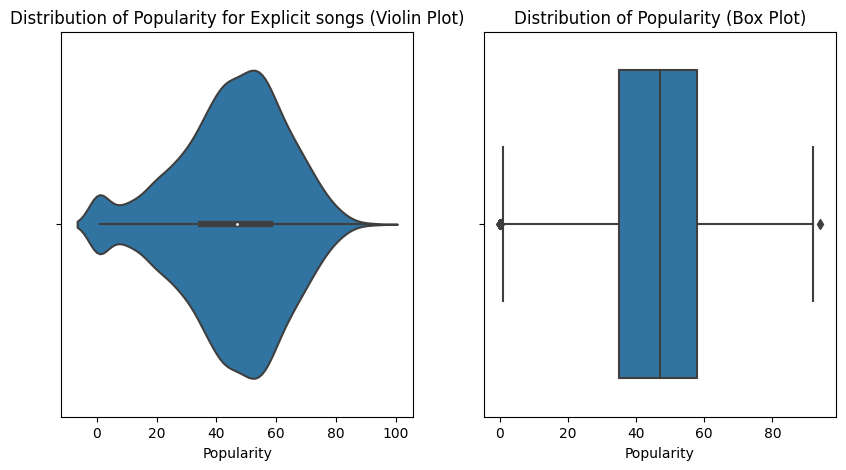

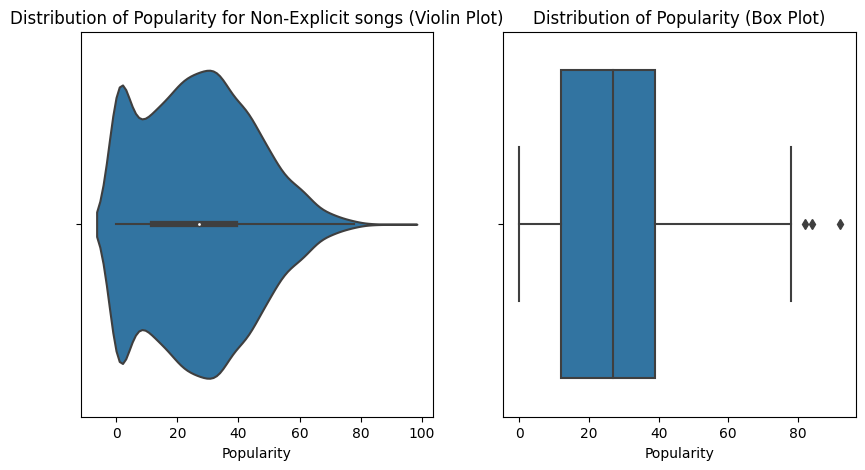

Popularity Statistics (Explicit):

mean      45.295902
median    47.000000
25%       35.000000
75%       58.000000
std       18.059123
Name: popularity, dtype: float64
Popularity Statistics (Non-Explicit):

mean      26.709417
median    27.000000
25%       12.000000
75%       39.000000
std       17.729563
Name: popularity, dtype: float64


In [62]:
# Create a violin plot and box plot of popularity
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.violinplot(x=explicit, ax=axes[0])
axes[0].set_title('Distribution of Popularity for Explicit songs (Violin Plot)')
axes[0].set_xlabel('Popularity')

sns.boxplot(x=explicit, ax=axes[1])
axes[1].set_title('Distribution of Popularity (Box Plot)')
axes[1].set_xlabel('Popularity')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.violinplot(x=non_explicit_sample, ax=axes[0])
axes[0].set_title('Distribution of Popularity for Non-Explicit songs (Violin Plot)')
axes[0].set_xlabel('Popularity')

sns.boxplot(x=non_explicit_sample, ax=axes[1])
axes[1].set_title('Distribution of Popularity (Box Plot)')
axes[1].set_xlabel('Popularity')


plt.show()

# Calculate the mean, median, quartiles, and variance of popularity
popularity_stats = explicit.describe()[['mean', '50%', '25%', '75%', 'std']]
popularity_stats.rename(index={'50%': 'median'}, inplace=True)

print('Popularity Statistics (Explicit):\n')
print(popularity_stats)



# Calculate the mean, median, quartiles, and variance of popularity
popularity_stats = non_explicit_sample.describe()[['mean', '50%', '25%', '75%', 'std']]
popularity_stats.rename(index={'50%': 'median'}, inplace=True)

print('Popularity Statistics (Non-Explicit):\n')
print(popularity_stats)

Looking at above, we can hypothesize that explicit songs tend to do better thanks to their high mean and median. Next, we will perform a statistical test to compare the two groups. We will be using a two-sample t-test, which can determine if the difference in means between two groups is statistically significant.

In [63]:
import scipy.stats as stats

# Conduct two-sample t-test
t, p = stats.ttest_ind(explicit, non_explicit_sample)

# Print t-test results
print('Two-Sample t-Test Results:')
print(f"t = {t:.3f}")
print(f"p = {p:.3f}")

# Determine if difference in means is significant
if p < 0.05:
    print("The difference in means is statistically significant.")
else:
    print("The difference in means is not statistically significant.")


Two-Sample t-Test Results:
t = 52.325
p = 0.000
The difference in means is statistically significant.


A very small p-value indicates that the difference in means is even less likely to be due to chance and provides strong evidence for the alternative hypothesis that there is a true difference between the two groups. It's important to note that while a significant result would suggest that explicit songs tend to have higher popularity than non-explicit songs, it does not necessarily prove causation. There may still be other confounding factors that are influencing the difference in means.

## Number of Artists and Popularity

Since the CSV only has a column called Artists which is an array of strings, firstly we will have to extract number of artists instead using pandas

In [64]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('tracks.csv')

# Extract the number of artists from the "artists" column and create a new column called num_artists
df['num_artists'] = df['artists'].str.count(',') + 1


Correlation coefficient: -0.071


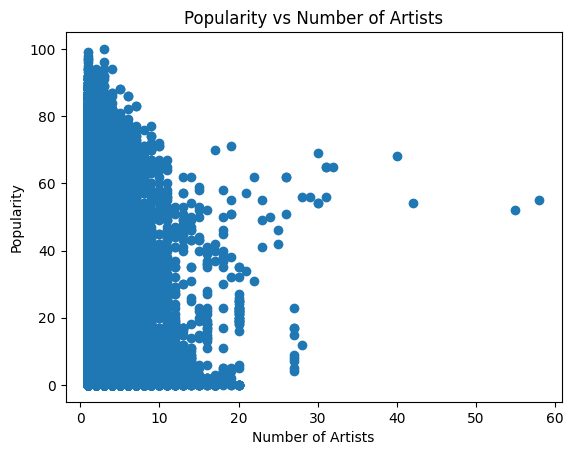

In [65]:
import matplotlib.pyplot as plt

# Create a scatter plot of popularity against number of artists
plt.scatter(df['num_artists'], df['popularity'])

# Add labels and title to the plot
plt.xlabel('Number of Artists')
plt.ylabel('Popularity')
plt.title('Popularity vs Number of Artists')

# Calculate the correlation coefficient
corr_coef = df['num_artists'].corr(df['popularity'])

# Print the correlation coefficient
print(f"Correlation coefficient: {corr_coef:.3f}")

# Show the plot
plt.show()

A correlation coefficient of -0.071 indicates a weak negative correlation between the two variables, popularity and the number of artists. This means that as the number of artists in a song increases, the popularity of the song tends to slightly decrease, but the relationship is not very strong.

Majority of the songs in our dataset have only one artist, it could potentially affect the results in our above analysis. This is because the range of the number of artists is limited, and the majority of the data falls within a narrow range. As a result, the relationship between the number of artists and popularity may not be fully captured.

To address this issue, we group the songs into categories based on the number of artists and analyze the relationship between popularity and the number of artists within each category. This would provide a more detailed view of how the number of artists affects popularity, and help to avoid bias towards songs with only one artist.

num_artists_bins             
(0, 1]            num_artists         NaN
(1, 5]            num_artists   -0.054386
(5, 10]           num_artists   -0.056122
(10, 20]          num_artists   -0.076623
(20, 50]          num_artists    0.244510
(50, 100]         num_artists    1.000000
(100, 1000]       num_artists         NaN
Name: popularity, dtype: float64


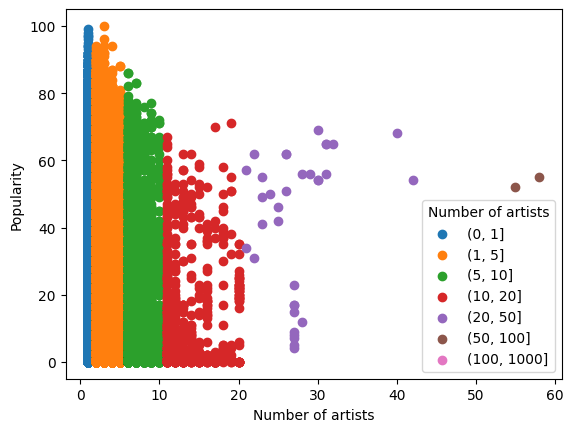

In [71]:
bins = [0, 1, 2, 5, 10, 20, 50, 100, 1000]
df['num_artists_bins'] = pd.cut(df['num_artists'], bins=bins)

grouped = df.groupby('num_artists_bins')
corr_df = grouped[['num_artists', 'popularity']].corr().iloc[0::2,-1]
print(corr_df)
for name, group in grouped:
    plt.scatter(group['num_artists'], group['popularity'], label=name)

plt.legend(title='Number of artists')
plt.xlabel('Number of artists')
plt.ylabel('Popularity')
plt.show()


None of the groups except for the 50-100 group have a high correlation coefficient. The perfect cooffcieint for the 50-100 group can be explained by the presence of only 2 data points. As such, we can conclude that number of artists has a very low correlation with popularity of songs.

## Release Year/Month and Popularity

Given that in the CSV somes dates are in the form of exact dates and some are in the form of exact years, we will first clean the data and only show it in the form of year.

In [74]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('tracks.csv')

# Extract the year from the "date" column and create a new column
df['year'] = df['release_date'].str.extract('(\d{4})', expand=False)


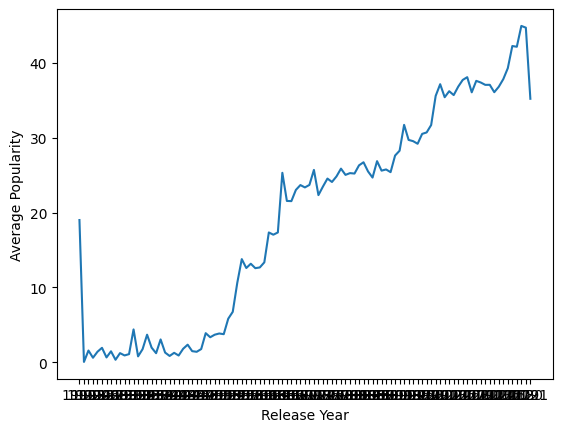

In [75]:

# Group the songs by release year and calculate the average popularity for each year
popularity_by_year = df.groupby('year')['popularity'].mean()

# Plot a line chart to visualize the relationship between release year and popularity
plt.plot(popularity_by_year.index, popularity_by_year.values)
plt.xlabel('Release Year')
plt.ylabel('Average Popularity')
plt.show()


An increasing line chart suggests that there is a positive trend between the variables being plotted. In the case of popularity vs. release year, an increasing line chart would suggest that as the years go on, on average, songs are becoming more popular. However, it's important to note that correlation does not necessarily imply causation and there are other factors in play. In this case, since the data is from Spotify songs released later are expected to do better when it comes to popularity on spotify. This is due to factors such as artists advertising their newly-released songs, music events covering mainly new songs etc 

Next, let us explore how release month affects popularity. Since there are songs present withouth their exact months and dates, these songs will be omitted from the analysis below

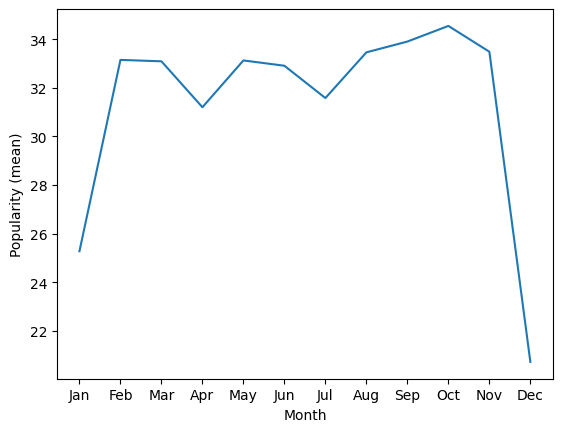

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('tracks.csv')

# Filter the DataFrame to only include rows with a month in the date
df = df[df['release_date'].str.len() > 4]

# Extract the month from the date column and create a new column
df['month'] = pd.to_datetime(df['release_date']).dt.month

# Group the DataFrame by month and calculate the mean popularity for each group
grouped = df.groupby('month')['popularity'].mean().reset_index()

# Map month numbers to month names
grouped['month'] = grouped['month'].apply(lambda x: calendar.month_abbr[x])

# Plot the popularity vs. month as a line graph
plt.plot(grouped['month'], grouped['popularity'])
plt.xlabel('Month')
plt.ylabel('Popularity (mean)')
plt.show()



Based on the above line-graph, a sharp difference in seen in Dec, Jan and the rest of the months. The rest of the months have a similar mean popularity in the rangge 31-34. Possible reasons for low popularity for songs released in Dec and Jan could be:

1. Competition: December and January are often considered the holiday season, where people may be more focused on festivities and spending time with loved ones rather than discovering new music. As a result, there may be more competition among new releases during these months, leading to a lower average popularity for all songs.
2. Release strategy: Some artists may strategically avoid releasing new music during December and January due to the holiday season's increased competition. As a result, the songs that are released during these months may be of lower quality or less well-known, leading to a lower average popularity for all songs.
3. Cultural factors: December and January may have different cultural and societal expectations and preferences for music. For example, December may be associated with Christmas music, which may not be as popular with some audiences, leading to a lower average popularity for all songs. Similarly, January may be associated with new beginnings and fresh starts, leading to different musical preferences than other months.

## Danceability and Popularity

Danceability Statistics:

mean      0.56
median    0.58
25%       0.45
75%       0.69
std       0.17
Name: danceability, dtype: object


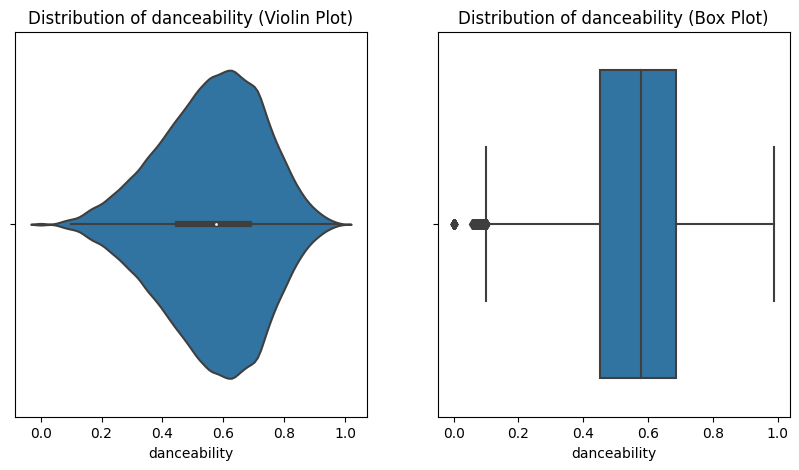

In [95]:
df = pd.read_csv('tracks.csv')

# Select a random sample of 20% of the data
df = df.sample(frac=0.2, random_state=42)

# Calculate the mean, median, quartiles, and variance of danceability
danceability_stats = df['danceability'].describe()[['mean', '50%', '25%', '75%', 'std']]
danceability_stats.rename(index={'50%': 'median'}, inplace=True)

# Convert the statistics to string with 2 decimal places
danceability_stats = danceability_stats.apply(lambda x: f'{x:.2f}')

print('Danceability Statistics:\n')
print(danceability_stats)


# Create a violin plot and box plot of duration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.violinplot(x=df['danceability'], ax=axes[0])
axes[0].set_title('Distribution of danceability (Violin Plot)')
axes[0].set_xlabel('danceability')

sns.boxplot(x=df['danceability'], ax=axes[1])
axes[1].set_title('Distribution of danceability (Box Plot)')
axes[1].set_xlabel('danceability')

plt.show()

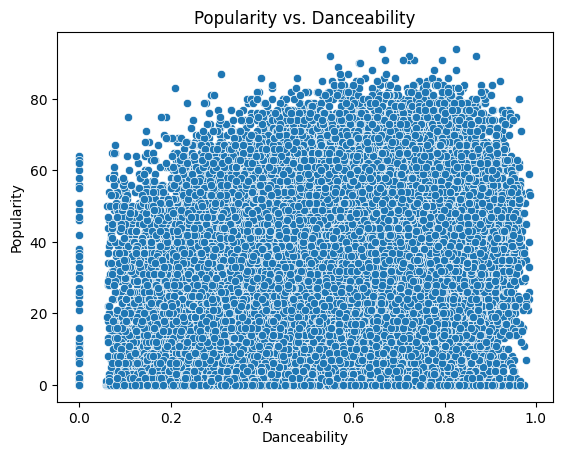

Correlation coefficient: 0.1862159126691714


In [96]:
#Next, let us see if there is a direct relationship between danceability and popularity through a scatter plot

# Create a scatter plot ofdanceability vs. popularity
sns.scatterplot(x='danceability', y='popularity', data=df)

# Set the plot title and axis labels
plt.title('Popularity vs. Danceability')
plt.xlabel('Danceability')
plt.ylabel('Popularity')

# Show the plot
plt.show()


# Calculate the correlation coefficient between danceability and popularity
corr = df['danceability'].corr(df['popularity'])

# Print the correlation coefficient to the console
print('Correlation coefficient:', corr)

A low correlation coefficient of 0.186 indicates a weak positive relationship between the two variables. This means that there may be some influence of danceability on the popularity of a song, but it is not a strong factor.

## Energy and Popularity

Energy Statistics:

mean      0.542
median    0.549
25%       0.343
75%       0.748
std       0.252
Name: energy, dtype: object


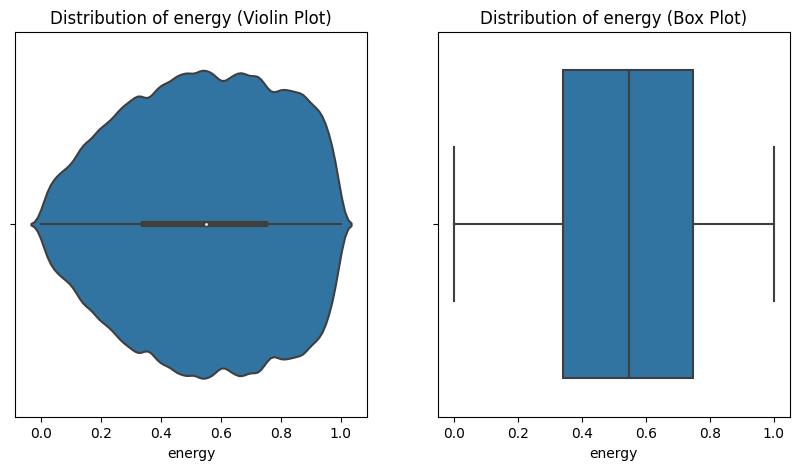

In [108]:
df = pd.read_csv('tracks.csv')

# Select a random sample of 20% of the data
# df = df.sample(frac=0.2, random_state=42)

# Calculate the mean, median, quartiles, and variance of energy
energy_stats = df['energy'].describe()[['mean', '50%', '25%', '75%', 'std']]
energy_stats.rename(index={'50%': 'median'}, inplace=True)

# Convert the statistics to string with 3 decimal places
energy_stats = energy_stats.apply(lambda x: f'{x:.3f}')

print('Energy Statistics:\n')
print(energy_stats)


# Create a violin plot and box plot of energy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.violinplot(x=df['energy'], ax=axes[0])
axes[0].set_title('Distribution of energy (Violin Plot)')
axes[0].set_xlabel('energy')

sns.boxplot(x=df['energy'], ax=axes[1])
axes[1].set_title('Distribution of energy (Box Plot)')
axes[1].set_xlabel('energy')

plt.show()

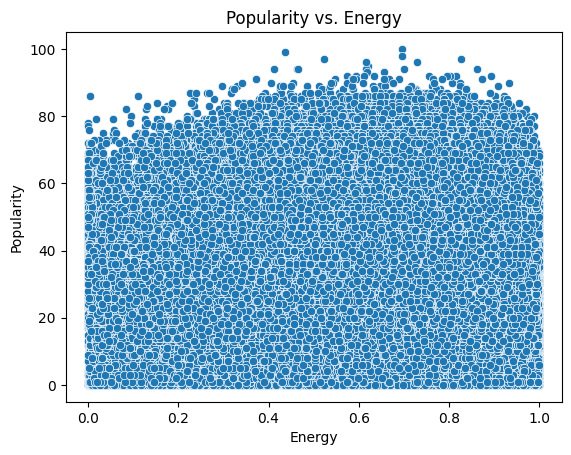

Correlation coefficient: 0.3023152217929189


In [109]:
#Next, let us see if there is a direct relationship between energy and popularity through a scatter plot

# Create a scatter plot of energy vs. popularity
sns.scatterplot(x='energy', y='popularity', data=df)

# Set the plot title and axis labels
plt.title('Popularity vs. Energy')
plt.xlabel('Energy')
plt.ylabel('Popularity')

# Show the plot
plt.show()


# Calculate the correlation coefficient between energy and popularity
corr = df['energy'].corr(df['popularity'])

# Print the correlation coefficient to the console
print('Correlation coefficient:', corr)

A correlation coefficient of 0.30 between popularity and danceability suggests a weak positive correlation between the two variables. This means that there is a tendency for songs with higher danceability to have slightly higher popularity on average, but the relationship is not very strong.

## Key and Popularity

Key Statistics:

mean      5.32
median    5.00
25%       2.00
75%       9.00
std       3.52
Name: key, dtype: object


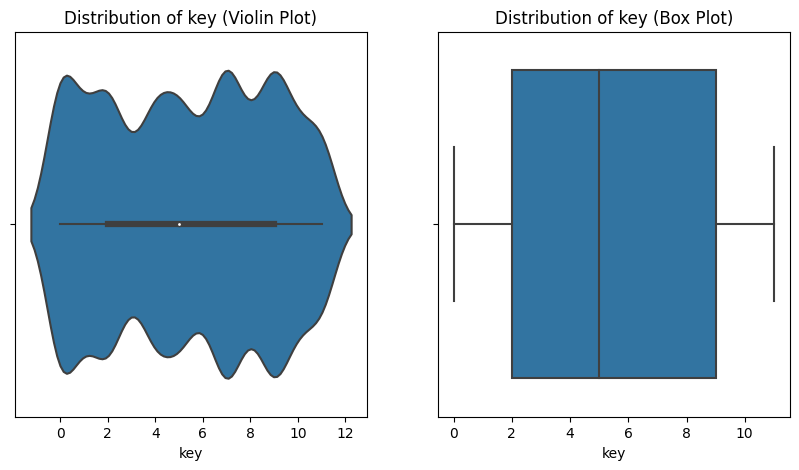

In [114]:
df = pd.read_csv('tracks.csv')

# Select a random sample of 20% of the data
df = df.sample(frac=0.2, random_state=42)

# Calculate the mean, median, quartiles, and variance of key
key_stats = df['key'].describe()[['mean', '50%', '25%', '75%', 'std']]
key_stats.rename(index={'50%': 'median'}, inplace=True)

# Convert the statistics to string with 2 decimal places
key_stats = key_stats.apply(lambda x: f'{x:.2f}')

print('Key Statistics:\n')
print(key_stats)


# Create a violin plot and box plot of key
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.violinplot(x=df['key'], ax=axes[0])
axes[0].set_title('Distribution of key (Violin Plot)')
axes[0].set_xlabel('key')

sns.boxplot(x=df['key'], ax=axes[1])
axes[1].set_title('Distribution of key (Box Plot)')
axes[1].set_xlabel('key')

plt.show()

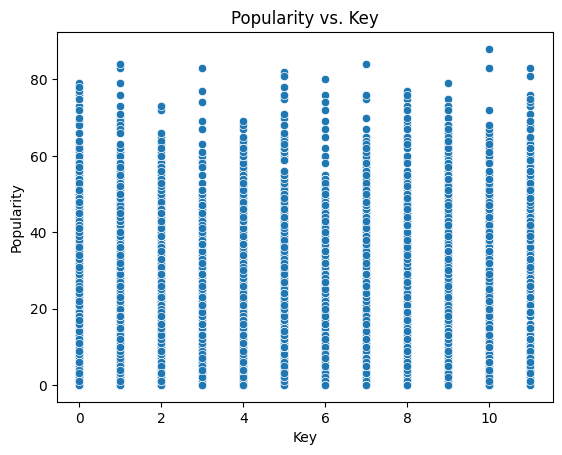

Correlation coefficient: 0.01772927424167988


In [115]:
#Next, let us see if there is a direct relationship between key and popularity through a scatter plot

# Create a scatter plot of key vs. popularity
sns.scatterplot(x='key', y='popularity', data=df)

# Set the plot title and axis labels
plt.title('Popularity vs. Key')
plt.xlabel('Key')
plt.ylabel('Popularity')

# Show the plot
plt.show()


# Calculate the correlation coefficient between energy and popularity
corr = df['key'].corr(df['popularity'])

# Print the correlation coefficient to the console
print('Correlation coefficient:', corr)

The above graph does not suggest much about the relationship between key and popularity. Let us next find the mean popularity for each key and see if there is a relationship based on that

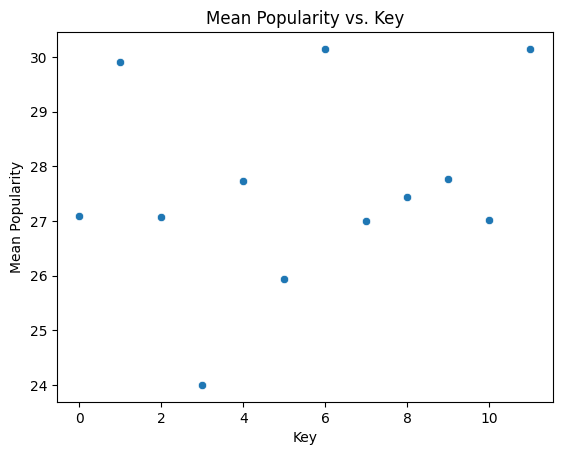

Correlation coefficient: 0.015107150845852114


In [119]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('tracks.csv')

# Select a random sample of 20% of the data
df = df.sample(frac=0.2, random_state=42)

# Group the DataFrame by key and calculate the mean popularity for each group
grouped = df.groupby('key')['popularity'].mean().reset_index()

# Create a scatter plot of key vs. mean popularity
sns.scatterplot(x='key', y='popularity', data=grouped)

# Set the plot title and axis labels
plt.title('Mean Popularity vs. Key')
plt.xlabel('Key')
plt.ylabel('Mean Popularity')

# Show the plot
plt.show()

# Calculate the correlation coefficient between key and popularity
corr = df['key'].corr(df['popularity'])

# Print the correlation coefficient to the console
print('Correlation coefficient:', corr)

As such, based on both the graphs above and the correlation value of 0.015, we can conclude that there is a very small or negligible relationship between the variables, and any association observed between them is most likely due to chance. Key thus plays a negligible part in determining popularity.

## Loudness and Popularity



Loudness Statistics:

mean      5.22
median    5.00
25%       2.00
75%       8.00
std       3.51
Name: key, dtype: object


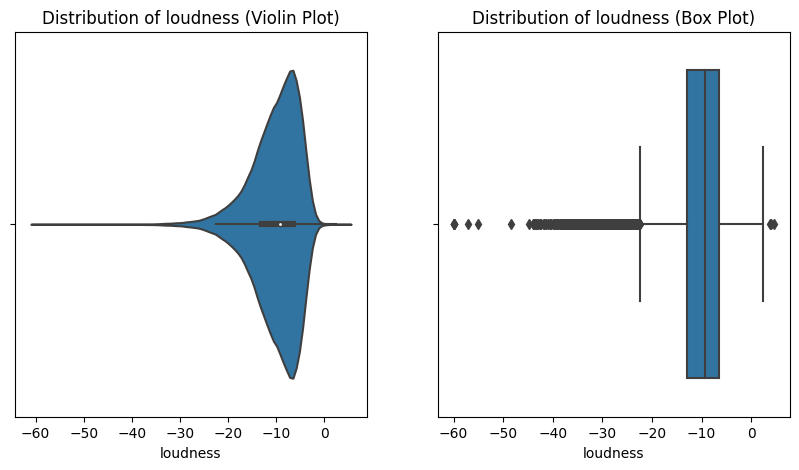

In [126]:
df = pd.read_csv('tracks.csv')

# Select a random sample of 20% of the data
df = df.sample(frac=0.2, random_state=42)

# Calculate the mean, median, quartiles, and variance of loudness
loudness_stats = df['key'].describe()[['mean', '50%', '25%', '75%', 'std']]
loudness_stats.rename(index={'50%': 'median'}, inplace=True)

# Convert the statistics to string with 2 decimal places
loudness_stats = loudness_stats.apply(lambda x: f'{x:.2f}')

print('Loudness Statistics:\n')
print(loudness_stats)

# Create a violin plot and box plot of loudness
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.violinplot(x=df['loudness'], ax=axes[0])
axes[0].set_title('Distribution of loudness (Violin Plot)')
axes[0].set_xlabel('loudness')

sns.boxplot(x=df['loudness'], ax=axes[1])
axes[1].set_title('Distribution of loudness (Box Plot)')
axes[1].set_xlabel('loudness')

plt.show()

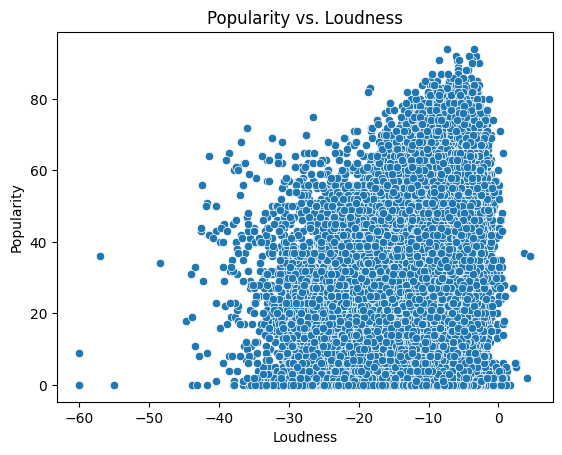

Correlation coefficient: 0.32998421404733597


In [127]:
#Next, let us see if there is a direct relationship between loudness and popularity through a scatter plot

# Create a scatter plot of loudness vs. popularity
sns.scatterplot(x='loudness', y='popularity', data=df)

# Set the plot title and axis labels
plt.title('Popularity vs. Loudness')
plt.xlabel('Loudness')
plt.ylabel('Popularity')

# Show the plot
plt.show()


# Calculate the correlation coefficient between loudness and popularity
corr = df['loudness'].corr(df['popularity'])

# Print the correlation coefficient to the console
print('Correlation coefficient:', corr)

A correlation coefficient of 0.32998421404733597 between popularity and loudness suggests that there is a positive correlation between these two variables. This means that as the loudness of a song increases, the popularity of the song tends to increase as well. However, the correlation coefficient of 0.329 is not very strong, so the relationship between these two variables may not be very significant.

## Mode and Popularity

Since mode is a binary (1 or 0) we will group the songs by their mode and analyse the popularity distribution based on that

Mode 0:
Number of data points: 200174
Mean popularity: 28.429141646767313
Median popularity: 28.0
Mode 1:
Number of data points: 386498
Mean popularity: 27.12511578326408
Median popularity: 27.0


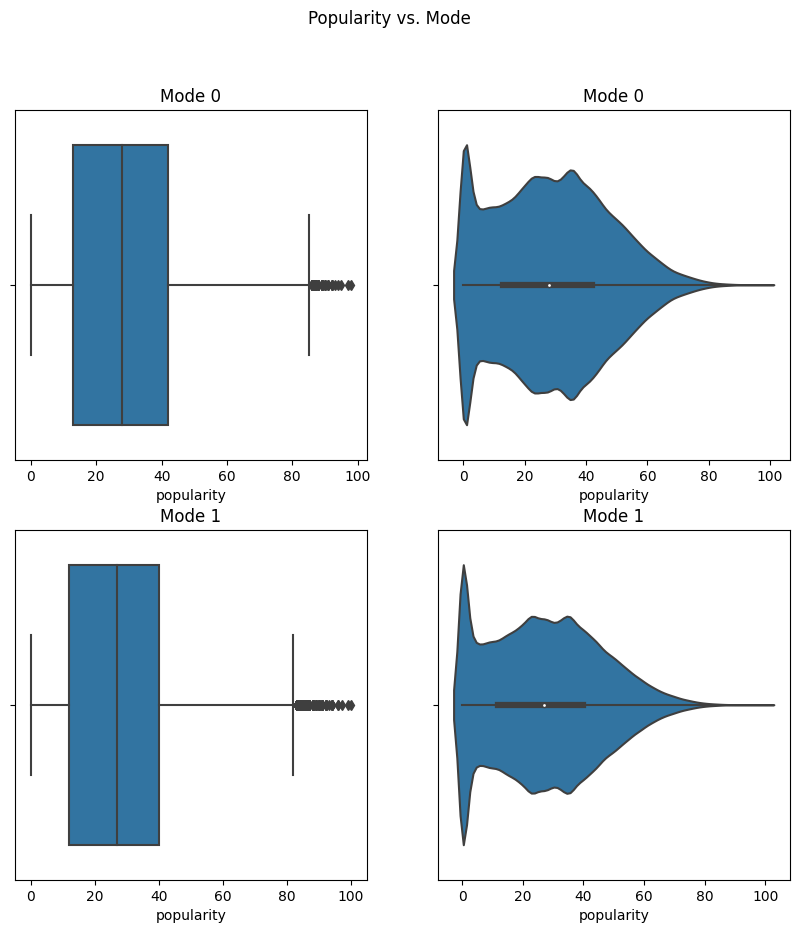

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('tracks.csv')

# Split the DataFrame by mode
mode0 = df[df['mode'] == 0]['popularity']
mode1 = df[df['mode'] == 1]['popularity']

print("Mode 0:")
print("Number of data points:", len(mode0))
print("Mean popularity:", mode0.mean())
print("Median popularity:", mode0.median())

print("Mode 1:")
print("Number of data points:", len(mode1))
print("Mean popularity:", mode1.mean())
print("Median popularity:", mode1.median())

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Create a boxplot of popularity for mode 0 in the first subplot
sns.boxplot(x=mode0, ax=axs[0, 0])
axs[0, 0].set_title('Mode 0')

# Create a violin plot of popularity for mode 0 in the second subplot
sns.violinplot(x=mode0, ax=axs[0, 1])
axs[0, 1].set_title('Mode 0')

# Create a boxplot of popularity for mode 1 in the third subplot
sns.boxplot(x=mode1, ax=axs[1, 0])
axs[1, 0].set_title('Mode 1')

# Create a violin plot of popularity for mode 1 in the fourth subplot
sns.violinplot(x=mode1, ax=axs[1, 1])
axs[1, 1].set_title('Mode 1')


# Set the overall title of the figure
fig.suptitle('Popularity vs. Mode')

# Show the plot
plt.show()




The plots and popularity distirbtuion for both modes look very similar. Similarly, median and mean popularity for both modes are close to each other. This suugests that mode does not affect popularity